In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Colab Notebooks/EECS595/project"

import os
import sys

assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5

GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['news_data.csv']


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
filename = 'news_data.csv'
file_path = os.path.join(GOOGLE_DRIVE_PATH, filename)

In [ ]:
df = pd.read_csv(file_path)

# multi-class classification and basic cleaning
unique_labels = df['Label'].unique()
print(unique_labels)
label2ind = {'pants-fire': 0, 'FALSE': 1, 'barely-true': 2, 'half-true': 3, "mostly-true": 4, "TRUE": 5}
df['Label'] = df['Label'].map(label2ind)
df = df.dropna(subset=['Label'])

X = df['News_Headline'].values
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

['FALSE' 'pants-fire' 'barely-true' 'TRUE' 'mostly-true' 'half-true'
 'full-flop' 'half-flip' 'no-flip']


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=100, return_sequences=True, dropout=0.2))
model.add(LSTM(units=100))
model.add(Dense(units=6, activation='softmax'))

optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 64

model.fit(X_train_pad, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/10
 72/111 [==================>...........] - ETA: 0s - loss: 1.7623 - accuracy: 0.2326

KeyboardInterrupt: ignored

In [ ]:
keras.utils.plot_model(model, "RNN_LSTM.png", show_shapes=True)

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f'Loss: {loss} Accuracy: {accuracy}')

62/62 [==============================] - 0s 8ms/step - loss: 1.7635 - accuracy: 0.2364
Loss: 1.7635360956192017 Accuracy: 0.23642821609973907


In [ ]:
# CNN Model
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
optimizer = Adam(learning_rate=0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(128, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))

cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 128
cnn_model.fit(X_train_pad, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

cnn_evaluation = cnn_model.evaluate(X_test_pad, y_test_encoded)
print(f'CNN Model Test Accuracy: {cnn_evaluation[1]}')

Epoch 1/10
56/56 [==============================] - 10s 183ms/step - loss: 0.0484 - accuracy: 0.9877 - val_loss: 7.2885 - val_accuracy: 0.2586
Epoch 2/10
56/56 [==============================] - 4s 73ms/step - loss: 0.0116 - accuracy: 0.9979 - val_loss: 7.6303 - val_accuracy: 0.2649
Epoch 3/10
56/56 [==============================] - 3s 47ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 7.7367 - val_accuracy: 0.2611
Epoch 4/10
56/56 [==============================] - 3s 57ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 7.9340 - val_accuracy: 0.2573
Epoch 5/10
56/56 [==============================] - 3s 48ms/step - loss: 7.6027e-04 - accuracy: 0.9999 - val_loss: 7.9743 - val_accuracy: 0.2624
Epoch 6/10
56/56 [==============================] - 1s 18ms/step - loss: 4.1657e-04 - accuracy: 1.0000 - val_loss: 8.0806 - val_accuracy: 0.2649
Epoch 7/10
56/56 [==============================] - 2s 27ms/step - loss: 2.9031e-04 - accuracy: 1.0000 - val_loss: 8.1243 - val_accuracy: 0.2662

In [ ]:
keras.utils.plot_model(cnn_model, "CNN.png", show_shapes=True)

In [ ]:
!pip install transformers
!pip install tensorflow

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

X_train_bert = tokenizer_bert(X_train.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')
X_test_bert = tokenizer_bert(X_test.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")

bert_output = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
bert_output = Dropout(0.2)(bert_output)
bert_output = Dense(6, activation='softmax')(bert_output)

optimizer = Adam(learning_rate=0.0001)

bert_keras_model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=bert_output)
bert_keras_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bert_keras_model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask'], X_train_bert['token_type_ids']],
    to_categorical(y_train, num_classes=6),
    epochs=3,
    batch_size=batch_size
)

Epoch 1/3


ResourceExhaustedError: ignored

In [ ]:
X_test_bert['input_ids'] = pad_sequences(X_test_bert['input_ids'], maxlen=max_len, padding='post', truncating='post')
X_test_bert['attention_mask'] = pad_sequences(X_test_bert['attention_mask'], maxlen=max_len, padding='post', truncating='post')
X_test_bert['token_type_ids'] = pad_sequences(X_test_bert['token_type_ids'], maxlen=max_len, padding='post', truncating='post')

In [ ]:
bert_evaluation = bert_keras_model.evaluate(
    [X_test_bert['input_ids'], X_test_bert['attention_mask'], X_test_bert['token_type_ids']],
    to_categorical(y_test, num_classes=6)
)

print(f'BERT Accuracy: {bert_evaluation[1]}')

ValueError: ignored

In [ ]:
from tensorflow.keras.layers import concatenate

lstm_output = model.get_layer(index=-2).output
combined_output = concatenate([lstm_output, bert_keras_model.output, cnn_model.output])

fusion_dense_1 = Dense(256, activation='relu')(combined_output)
fusion_dense_2 = Dense(128, activation='relu')(fusion_dense_1)
fusion_output = Dense(6, activation='softmax')(fusion_dense_2)

fusion_model = Model(inputs=[model.input, bert_keras_model.input, cnn_model.input], outputs=fusion_output)

fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fusion_model.fit([X_train_pad, X_train_bert['input_ids'], X_train_bert['attention_mask'], X_train_bert['token_type_ids'], X_train_pad], y_train_encoded, epochs=2, batch_size=batch_size, validation_split=0.1)
fusion_evaluation = fusion_model.evaluate([X_test_pad, X_test_bert['input_ids'], X_test_bert['attention_mask'], X_test_bert['token_type_ids'], X_test_pad], y_test_encoded)
print(f'Fusion Model Test Accuracy: {fusion_evaluation[1]}')
# fusion_model.summary()

Epoch 1/2
111/111 [==============================] - 200s 1s/step - loss: 0.3346 - accuracy: 0.9839 - val_loss: 3.6374 - val_accuracy: 0.2636
Epoch 2/2
62/62 [==============================] - 13s 217ms/step - loss: 4.4517 - accuracy: 0.2593
Fusion Model Test Accuracy: 0.25925925374031067


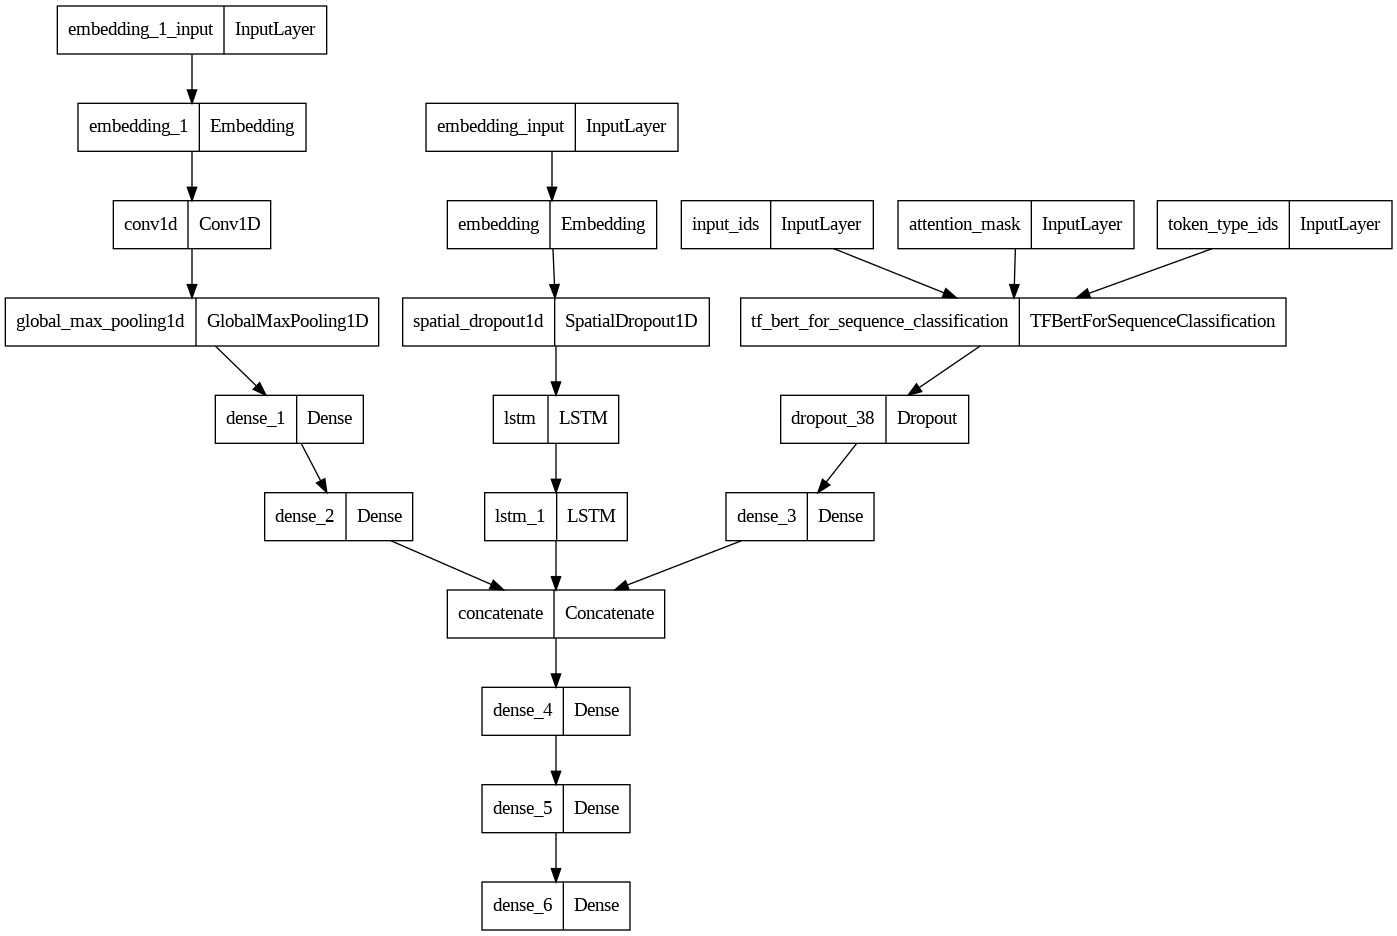

In [ ]:
keras.utils.plot_model(fusion_model, "Fusion.png")

In [ ]:
lstm_output = model.get_layer(index=-2).output
combined_output = concatenate([lstm_output, cnn_model.output])

fusion_dense_1 = Dense(256, activation='relu')(combined_output)
fusion_dense_2 = Dense(128, activation='relu')(fusion_dense_1)
fusion_output = Dense(6, activation='softmax')(fusion_dense_2)

optimizer = Adam(learning_rate=0.0001)

RNN_CNN_fusion = Model(inputs=[model.input, cnn_model.input], outputs=fusion_output)

RNN_CNN_fusion.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
RNN_CNN_fusion.fit([X_train_pad, X_train_pad], y_train_encoded, epochs=3, batch_size=batch_size, validation_split=0.1)
fusion_evaluation = RNN_CNN_fusion.evaluate([X_test_pad, X_test_pad], y_test_encoded)
print(f'RNN CNN Fusion Results: {fusion_evaluation[1]}')

In [ ]:
def predict_bert(model, generator):
    all_logits = []
    for batch in generator:
        logits = model.predict(batch)['logits']
        all_logits.append(logits)
    return np.concatenate(all_logits, axis=0)

bert_predictions = predict_bert(bert_model, BertDataGenerator(X_test, y_test, batch_size=batch_size, tokenizer=tokenizer_bert, max_len=max_len))
lstm_predictions = model.predict(X_test_pad)

NameError: ignored

In [ ]:
fusion_input = np.concatenate([lstm_predictions, bert_predictions], axis=1)

fusion_model = Sequential()
fusion_model.add(Dense(units=6, activation='softmax', input_dim=fusion_input.shape[1]))
from tensorflow.keras.layers import concatenate

fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fusion_model.fit(fusion_input, to_categorical(y_test, num_classes=6), epochs=epochs, batch_size=batch_size, validation_split=0.1)
fusion_loss, fusion_accuracy = fusion_model.evaluate(fusion_input, to_categorical(y_test, num_classes=6))